# Global YouTube Statistics — Structured Analysis Notebook

This notebook analyzes the *Global YouTube Statistics* dataset, addressing the questions from the project brief.  
It includes robust preprocessing, exploratory analysis, correlation checks, geospatial distributions, and time-based trends.

> Data source: **Global YouTube Statistics.csv** (included alongside this notebook).  
> If you move the CSV, update `DATA_PATH` in the next section.

**Note:** All charts use **matplotlib** with one figure per cell (no seaborn styles).


## 1) Setup & Load Data

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 100)
pd.set_option("display.float_format", lambda x: f"{x:,.2f}")

# Path (assumes CSV is next to this notebook)
DATA_PATH = "/content/Global YouTube Statistics.csv"

# Read with fallback encoding
df_raw = pd.read_csv(DATA_PATH, encoding="latin1")
print("Rows (raw):", len(df_raw))
df_raw.head(3)


Rows (raw): 1006


,rank,Youtuber,subscribers,video views,category,Title,uploads,Country of origin,Country,Abbreviation,channel_type,video_views_rank,country_rank,channel_type_rank,video_views_for_the_last_30_days,lowest_monthly_earnings,highest_monthly_earnings,lowest_yearly_earnings,highest_yearly_earnings,subscribers_for_last_30_days,created_year,created_month,created_date,Gross tertiary education enrollment (%),Population,Unemployment rate,Urban_population,Latitude,Longitude
0,1,T-Series,"245,000,000.00","228,000,000,000.00",Music,T-Series,20082,India,india,IN,Music,1.00,1.00,1.00,"2,258,000,000.00","564,600.00","9,000,000.00","6,800,000.00","108,400,000.00","2,000,000.00","2,006.00",Mar,13.00,28.10,"1,366,417,754.00",5.36,"471,031,528.00",20.59,78.96
1,2,YouTube Movies,"170,000,000.00",0.00,Film & Animation,youtubemovies,1,United States,United States,US,Games,"4,055,159.00","7,670.00","7,423.00",12.00,0.00,0.05,0.04,0.58,NaN,"2,006.00",NaN,5.00,88.20,"328,239,523.00",14.70,"270,663,028.00",37.09,-95.71
2,3,MrBeast,"166,000,000.00","28,368,841,870.00",Entertainment,MrBeast,741,United States,United States,US,Entertainment,48.00,1.00,1.00,"1,348,000,000.00","337,000.00","5,400,000.00","4,000,000.00","64,700,000.00","8,000,000.00","2,012.00",Feb,20.00,88.20,"328,239,523.00",14.70,"270,663,028.00",37.09,-95.71


## 2) Preprocessing (clean columns, types, dates, nulls)

In [5]:
df = df_raw.copy()

# 2.1 Standardize column names: lower + underscores
def clean_col(c):
    return (c.strip()
             .replace(" ", "_")
             .replace("-", "_")
             .replace("/", "_")
             .replace("__", "_")
             .lower())
df.columns = [clean_col(c) for c in df.columns]

# 2.2 De-duplicate
df = df.drop_duplicates().reset_index(drop=True)

# 2.3 Coerce numeric columns (remove commas, $)
def to_num(s):
    if pd.isna(s):
        return np.nan
    if isinstance(s, (int, float)):
        return s
    s = str(s).replace(",", "").replace("$", "").strip()
    mult = 1
    if s.endswith(("M","m")):
        mult = 1_000_000; s = s[:-1]
    elif s.endswith(("K","k")):
        mult = 1_000; s = s[:-1]
    try:
        return float(s) * mult
    except:
        return np.nan

num_like = [
    "rank","subscribers","video_views","uploads",
    "video_views_rank","country_rank","channel_type_rank",
    "video_views_for_the_last_30_days",
    "lowest_monthly_earnings","highest_monthly_earnings",
    "lowest_yearly_earnings","highest_yearly_earnings",
    "subscribers_for_last_30_days",
    "created_year","created_date",
    "gross_tertiary_education_enrollment_%","population",
    "unemployment_rate","urban_population","latitude","longitude"
]

for c in num_like:
    if c in df.columns:
        df[c] = df[c].apply(to_num)

# 2.4 Construct created_datetime from year+month+date (month may be name)
month_map = {m.lower(): i for i, m in enumerate(["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"], start=1)}
if "created_month" in df.columns:
    # Fill NaN months with a default value (e.g., 1 for January) before mapping
    created_month_num = (df["created_month"].fillna("Jan").astype(str).str.strip().str.lower().map(lambda x: month_map.get(x[:3], np.nan) if x and x != "nan" else np.nan))
else:
    created_month_num = np.nan

if "created_year" in df.columns and "created_date" in df.columns:
    df["created_datetime"] = pd.to_datetime(
        dict(
            # Fill NaN years and dates with a default value (e.g., 1900 for year, 1 for day)
            year=df["created_year"].fillna(1900).astype("Int64", errors="ignore"),
            month=created_month_num.fillna(1).astype("Int64", errors="ignore") if isinstance(created_month_num, pd.Series) else 1,
            day=df["created_date"].fillna(1).astype("Int64", errors="ignore")
        ),
        errors="coerce"
    )
else:
    df["created_datetime"] = pd.NaT


# 2.5 Fill/clean key categoricals
for cat in ["youtuber","category","title","country","abbreviation","channel_type","country_of_origin"]:
    if cat in df.columns:
        df[cat] = df[cat].astype(str).str.strip()

print("Rows (cleaned):", len(df))
display(df.head(3))

Rows (cleaned): 995


,rank,youtuber,subscribers,video_views,category,title,uploads,country_of_origin,country,abbreviation,channel_type,video_views_rank,country_rank,channel_type_rank,video_views_for_the_last_30_days,lowest_monthly_earnings,highest_monthly_earnings,lowest_yearly_earnings,highest_yearly_earnings,subscribers_for_last_30_days,created_year,created_month,created_date,gross_tertiary_education_enrollment_(%),population,unemployment_rate,urban_population,latitude,longitude,created_datetime
0,1,T-Series,"245,000,000.00","228,000,000,000.00",Music,T-Series,20082,India,india,IN,Music,1.00,1.00,1.00,"2,258,000,000.00","564,600.00","9,000,000.00","6,800,000.00","108,400,000.00","2,000,000.00","2,006.00",Mar,13.00,28.10,"1,366,417,754.00",5.36,"471,031,528.00",20.59,78.96,2006-03-13
1,2,YouTube Movies,"170,000,000.00",0.00,Film & Animation,youtubemovies,1,United States,United States,US,Games,"4,055,159.00","7,670.00","7,423.00",12.00,0.00,0.05,0.04,0.58,NaN,"2,006.00",NaN,5.00,88.20,"328,239,523.00",14.70,"270,663,028.00",37.09,-95.71,2006-01-05
2,3,MrBeast,"166,000,000.00","28,368,841,870.00",Entertainment,MrBeast,741,United States,United States,US,Entertainment,48.00,1.00,1.00,"1,348,000,000.00","337,000.00","5,400,000.00","4,000,000.00","64,700,000.00","8,000,000.00","2,012.00",Feb,20.00,88.20,"328,239,523.00",14.70,"270,663,028.00",37.09,-95.71,2012-02-20


## 3) Top 10 YouTube channels by subscribers

In [6]:
top10_subs = df.sort_values("subscribers", ascending=False)[["youtuber","subscribers","category","country"]].head(10)
top10_subs.reset_index(drop=True)

,youtuber,subscribers,category,country
0,T-Series,"245,000,000.00",Music,india
1,YouTube Movies,"170,000,000.00",Film & Animation,United States
2,MrBeast,"166,000,000.00",Entertainment,United States
3,Cocomelon - Nursery Rhymes,"162,000,000.00",Education,United States
4,SET India,"159,000,000.00",Shows,India
5,Music,"119,000,000.00",nan,nan
6,ýýý Kids Diana Show,"112,000,000.00",People & Blogs,United States
7,PewDiePie,"111,000,000.00",Gaming,Japan
8,Like Nastya,"106,000,000.00",People & Blogs,Russia
9,Vlad and Niki,"98,900,000.00",Entertainment,United States


## 4) Category with highest average subscribers

In [7]:
cat_avg_subs = df.groupby("category", dropna=False)["subscribers"].mean().sort_values(ascending=False)
cat_avg_subs.head(10)

,subscribers
category,
Shows,"41,615,384.62"
Trailers,"39,000,000.00"
Nonprofits & Activism,"27,750,000.00"
Film & Animation,"27,627,272.73"
Sports,"27,109,090.91"
Education,"26,542,222.22"
Music,"25,773,631.84"
Movies,"25,650,000.00"
nan,"25,488,679.25"


## 5) Average uploads by category

In [8]:
avg_uploads_cat = df.groupby("category", dropna=False)["uploads"].mean().sort_values(ascending=False)
avg_uploads_cat.head(15)

,uploads
category,
News & Politics,"112,484.38"
Nonprofits & Activism,"102,912.00"
Shows,"27,443.69"
Sports,"14,493.73"
Entertainment,"12,052.45"
People & Blogs,"9,256.79"
Trailers,"6,839.00"
Pets & Animals,"4,451.50"
Gaming,"4,313.41"


## 6) Top 5 countries with highest number of channels

In [9]:
channels_per_country = df.groupby("country", dropna=False)["youtuber"].nunique().sort_values(ascending=False)
channels_per_country.head(5)

,youtuber
country,
United States,313
India,167
nan,122
Brazil,62
United Kingdom,43


## 7) Distribution of channel types across categories

In [10]:
ct_cross = pd.crosstab(df["category"], df["channel_type"])
ct_cross.head(10)

channel_type,Animals,Autos,Comedy,Education,Entertainment,Film,Games,Howto,Music,News,Nonprofit,People,Sports,Tech,nan
category,,,,,,,,,,,,,,,
Autos & Vehicles,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
Comedy,0,0,38,0,20,1,3,0,0,0,0,5,0,0,2
Education,0,0,0,35,3,2,2,0,0,0,0,3,0,0,0
Entertainment,0,1,5,2,168,6,11,0,22,3,0,11,0,1,8
Film & Animation,0,0,1,2,16,17,3,0,3,0,0,2,0,0,1
Gaming,0,1,1,0,18,2,63,0,0,0,0,6,0,1,2
Howto & Style,0,0,0,0,7,0,0,26,0,0,0,2,0,1,3
Movies,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0
Music,0,0,0,1,12,5,2,0,174,1,0,2,1,0,3


## 8) Correlation: subscribers vs total video views

Correlation (Pearson) subscribers vs video_views: 0.751


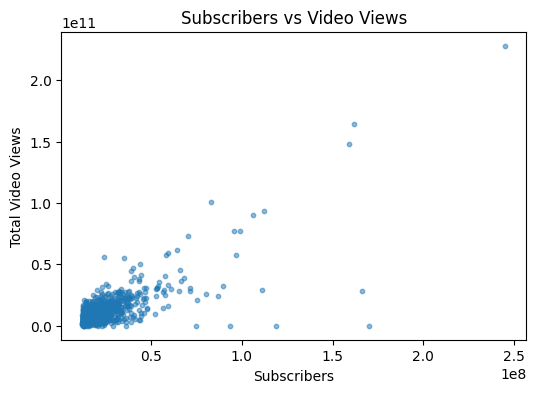

In [11]:
subset = df[["subscribers","video_views"]].dropna()
corr = subset.corr().iloc[0,1]
print(f"Correlation (Pearson) subscribers vs video_views: {corr:.3f}")

plt.figure(figsize=(6,4))
plt.scatter(subset["subscribers"], subset["video_views"], s=10, alpha=0.5)
plt.xlabel("Subscribers"); plt.ylabel("Total Video Views"); plt.title("Subscribers vs Video Views")
plt.show()

## 9) Monthly earnings across categories (lowest & highest)

In [12]:
earn_cat = df.groupby("category")[["lowest_monthly_earnings","highest_monthly_earnings"]].mean().sort_values("highest_monthly_earnings", ascending=False)
earn_cat.head(15)

,lowest_monthly_earnings,highest_monthly_earnings
category,,
Shows,"126,961.54","2,037,661.54"
Autos & Vehicles,"68,300.00","1,086,350.00"
nan,"56,316.08","901,093.78"
Sports,"50,063.64","806,936.36"
Pets & Animals,"49,975.50","794,432.25"
Film & Animation,"46,802.53","748,984.07"
Education,"43,371.31","695,177.78"
Comedy,"41,867.54","668,312.22"
News & Politics,"40,192.62","642,631.96"


## 10) Trend in subscribers gained (last 30 days)

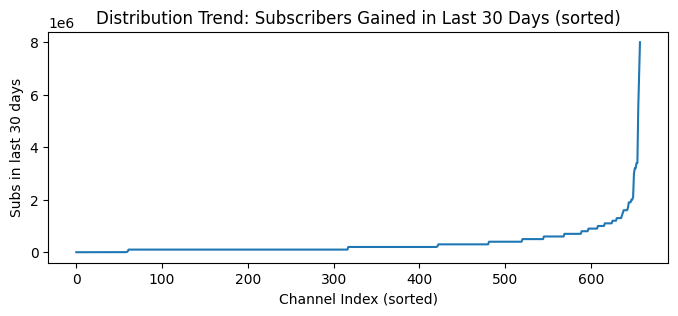

,subscribers_for_last_30_days
count,658.00
mean,"349,079.13"
std,"614,355.44"
min,1.00
25%,"100,000.00"
50%,"200,000.00"
75%,"400,000.00"
max,"8,000,000.00"


In [13]:
subs_30 = df["subscribers_for_last_30_days"].dropna()
plt.figure(figsize=(8,3))
plt.plot(np.arange(len(subs_30)), subs_30.sort_values().values)
plt.title("Distribution Trend: Subscribers Gained in Last 30 Days (sorted)")
plt.xlabel("Channel Index (sorted)"); plt.ylabel("Subs in last 30 days")
plt.show()

subs_30.describe()

## 11) Outliers in yearly earnings

In [15]:
yr = df[["lowest_yearly_earnings","highest_yearly_earnings"]].dropna()
q1 = yr.quantile(0.25); q3 = yr.quantile(0.75); iqr = q3 - q1
upper = q3 + 1.5*iqr; lower = q1 - 1.5*iqr

outliers = df[
    (df["highest_yearly_earnings"] > upper["highest_yearly_earnings"]) |
    (df["lowest_yearly_earnings"] < lower["lowest_yearly_earnings"])
][["youtuber","category","country","lowest_yearly_earnings","highest_yearly_earnings"]]

print("Outliers rows:", len(outliers))
outliers.head(20)

Outliers rows: 99


,youtuber,category,country,lowest_yearly_earnings,highest_yearly_earnings
0,T-Series,Music,india,"6,800,000.00","108,400,000.00"
2,MrBeast,Entertainment,United States,"4,000,000.00","64,700,000.00"
3,Cocomelon - Nursery Rhymes,Education,United States,"5,900,000.00","94,800,000.00"
4,SET India,Shows,India,"5,500,000.00","87,500,000.00"
6,ýýý Kids Diana Show,People & Blogs,United States,"2,200,000.00","35,100,000.00"
9,Vlad and Niki,Entertainment,United States,"1,700,000.00","27,900,000.00"
10,Zee Music Company,Music,India,"2,400,000.00","38,600,000.00"
11,WWE,Sports,United States,"2,100,000.00","34,300,000.00"
13,BLACKPINK,nan,South Korea,"1,500,000.00","23,900,000.00"
15,Sony SAB,Shows,India,"5,000,000.00","79,600,000.00"


## 12) Distribution of channel creation dates / trend over time

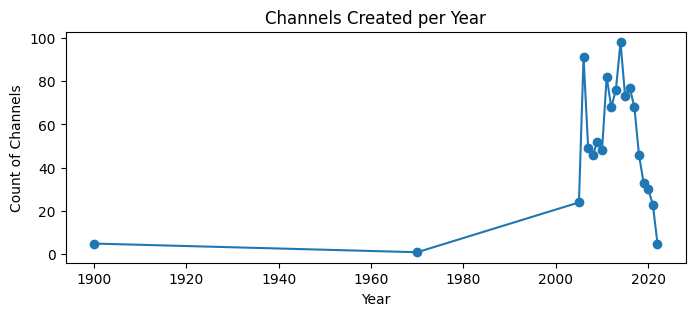

In [16]:
if df["created_datetime"].notna().any():
    by_year = df.dropna(subset=["created_datetime"]).groupby(df["created_datetime"].dt.year)["youtuber"].nunique()
    plt.figure(figsize=(8,3))
    plt.plot(by_year.index, by_year.values, marker="o")
    plt.title("Channels Created per Year")
    plt.xlabel("Year"); plt.ylabel("Count of Channels")
    plt.show()
    by_year.tail(15)
else:
    print("created_datetime not available.")

## 13) Gross tertiary education enrollment vs number of channels (by country)

In [17]:
if "gross_tertiary_education_enrollment_%" in df.columns:
    agg = df.groupby("country").agg(
        channels=("youtuber","nunique"),
        tertiary=("gross_tertiary_education_enrollment_%","mean")
    ).dropna()
    plt.figure(figsize=(6,4))
    plt.scatter(agg["tertiary"], agg["channels"])
    plt.xlabel("Gross tertiary education enrollment (%)")
    plt.ylabel("Number of channels")
    plt.title("Tertiary Enrollment vs Channels")
    plt.show()
    agg.sort_values("channels", ascending=False).head(10)
else:
    print("Column gross_tertiary_education_enrollment_% not present.")

Column gross_tertiary_education_enrollment_% not present.


## 14) Unemployment rate among top 10 countries by channels

In [18]:
top10_countries = (df.groupby("country")["youtuber"].nunique()
                     .sort_values(ascending=False).head(10).index)
unemp = df[df["country"].isin(top10_countries)].groupby("country")["unemployment_rate"].mean().sort_values(ascending=False)
unemp

,unemployment_rate
country,
United States,14.70
Spain,13.96
Brazil,12.08
India,5.36
Indonesia,4.69
South Korea,4.15
United Kingdom,3.85
Mexico,3.42
Thailand,0.75


## 15) Average urban population percentage

In [19]:
urban_avg = df.groupby("country")["urban_population"].mean().sort_values(ascending=False)
urban_avg.head(10)

,urban_population
country,
China,"842,933,962.00"
india,"471,031,528.00"
India,"471,031,528.00"
United States,"270,663,028.00"
Brazil,"183,241,641.00"
Indonesia,"151,509,724.00"
Japan,"115,782,416.00"
Russia,"107,683,889.00"
Mexico,"102,626,859.00"


## 16) Geographic distribution (lat/long)

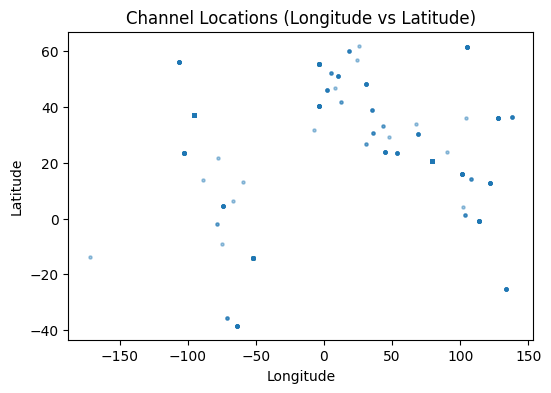

Plotted 872 points.


In [20]:
geo = df[["latitude","longitude"]].dropna()
plt.figure(figsize=(6,4))
plt.scatter(geo["longitude"], geo["latitude"], s=5, alpha=0.4)
plt.title("Channel Locations (Longitude vs Latitude)")
plt.xlabel("Longitude"); plt.ylabel("Latitude")
plt.show()
print("Plotted", len(geo), "points.")

## 17) Correlation: subscribers vs country population

Correlation (Pearson) total_subs vs population: 0.341


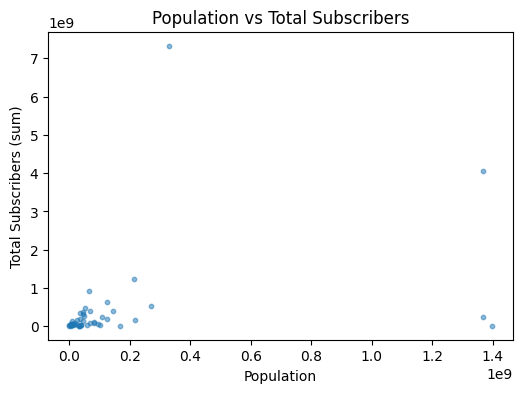

In [21]:
agg = df.groupby("country").agg(
    total_subs=("subscribers","sum"),
    population=("population","mean")
).dropna()
corr = agg.corr().iloc[0,1]
print(f"Correlation (Pearson) total_subs vs population: {corr:.3f}")
plt.figure(figsize=(6,4))
plt.scatter(agg["population"], agg["total_subs"], s=10, alpha=0.5)
plt.xlabel("Population"); plt.ylabel("Total Subscribers (sum)"); plt.title("Population vs Total Subscribers")
plt.show()

## 18) Top 10 countries by channels vs population

In [22]:
top10 = df.groupby("country")["youtuber"].nunique().sort_values(ascending=False).head(10)
compare = df[df["country"].isin(top10.index)].groupby("country").agg(
    channels=("youtuber","nunique"),
    population=("population","mean")
).sort_values("channels", ascending=False)
compare

,channels,population
country,,
United States,313,"328,239,523.00"
India,167,"1,366,417,754.00"
nan,122,NaN
Brazil,62,"212,559,417.00"
United Kingdom,43,"66,834,405.00"
Mexico,33,"126,014,024.00"
Indonesia,28,"270,203,917.00"
Spain,22,"47,076,781.00"
Thailand,18,"69,625,582.00"


## 19) Correlation: subscribers gained (30d) vs unemployment rate

Correlation (Pearson) subs_30 vs unemployment: 0.213


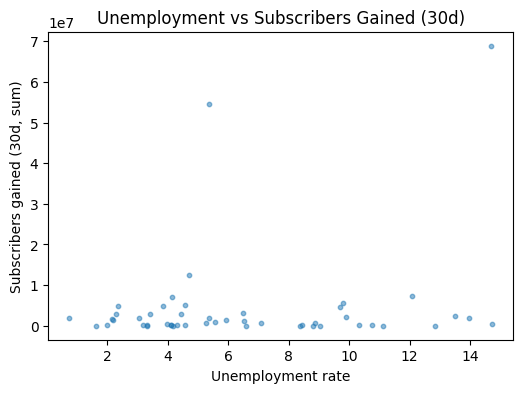

In [23]:
agg = df.groupby("country").agg(
    subs_30=("subscribers_for_last_30_days","sum"),
    unemployment=("unemployment_rate","mean")
).dropna()
corr = agg.corr().iloc[0,1]
print(f"Correlation (Pearson) subs_30 vs unemployment: {corr:.3f}")
plt.figure(figsize=(6,4))
plt.scatter(agg["unemployment"], agg["subs_30"], s=10, alpha=0.5)
plt.xlabel("Unemployment rate"); plt.ylabel("Subscribers gained (30d, sum)")
plt.title("Unemployment vs Subscribers Gained (30d)")
plt.show()

## 20) Video views (last 30 days) across channel types

In [24]:
views30_by_type = df.groupby("channel_type")["video_views_for_the_last_30_days"].sum().sort_values(ascending=False)
views30_by_type

,video_views_for_the_last_30_days
channel_type,
Entertainment,"63,861,841,055.00"
Music,"37,532,535,662.00"
People,"17,207,361,493.00"
Comedy,"9,600,746,623.00"
Education,"9,220,914,001.00"
Games,"8,598,094,041.00"
Film,"5,763,538,061.00"
News,"5,250,125,924.00"
Sports,"2,128,495,004.00"


## 21) Seasonal trends in uploads (proxy by created month)

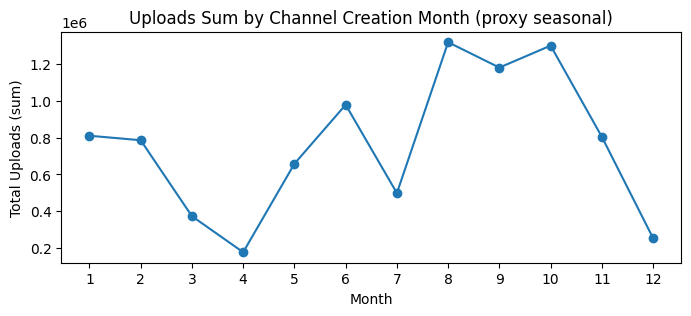

In [25]:
if df["created_datetime"].notna().any():
    by_month = df.dropna(subset=["created_datetime"]).groupby(df["created_datetime"].dt.month)["uploads"].sum()
    plt.figure(figsize=(8,3))
    plt.plot(by_month.index, by_month.values, marker="o")
    plt.title("Uploads Sum by Channel Creation Month (proxy seasonal)")
    plt.xlabel("Month"); plt.ylabel("Total Uploads (sum)")
    plt.xticks(range(1,13))
    plt.show()
    by_month
else:
    print("created_datetime not available to infer seasonal proxy.")

## 22) Average subscribers gained per month since creation

In [26]:
from datetime import datetime

if df["created_datetime"].notna().any():
    today = pd.Timestamp.today().normalize()
    age_months = (today.to_period("M") - df["created_datetime"].dt.to_period("M")).apply(lambda p: p.n)
    age_months = age_months.replace(0, np.nan)
    df["avg_subs_per_month_since_creation"] = df["subscribers"] / age_months
    df[["youtuber","subscribers","created_datetime","avg_subs_per_month_since_creation"]].head(15)
else:
    print("created_datetime not available.")

## 23) Quick KPI Summary

In [27]:
kpis = {
    "channels": int(df["youtuber"].nunique() if "youtuber" in df.columns else len(df)),
    "countries": int(df["country"].nunique() if "country" in df.columns else 0),
    "categories": int(df["category"].nunique() if "category" in df.columns else 0),
    "total_subscribers": float(df["subscribers"].sum(skipna=True)),
    "total_views": float(df["video_views"].sum(skipna=True)),
    "avg_last30_subs": float(df["subscribers_for_last_30_days"].mean(skipna=True)),
}
kpis

{'channels': 995,
 'countries': 51,
 'categories': 19,
 'total_subscribers': 22830300000.0,
 'total_views': 10984339366778.0,
 'avg_last30_subs': 349079.13221884496}